In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from skimage import io, transform
from keras.models import Model,Sequential, load_model
from keras.applications.inception_resnet_v2 import InceptionResNetV2#, preprocess_input
# from keras.applications import MobileNet
# from keras.applications.mobilenet import preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.layers import Dropout, Dense, Flatten, Input
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils as u
from keras import optimizers
from sklearn.metrics import f1_score
from statistics import mean

Using TensorFlow backend.


In [2]:
def PreProcessImage(path):
    img = io.imread(path)   
    resize = transform.resize(img, (224, 224))
    #io.imshow(resize)
    sample = np.asarray(resize)
    #print(sample)
    return sample

In [3]:
f = open('train.csv')

biz2label = {}
first = True

for line in f:
    if (first):
        first = False
        continue
    biz = line.split(',')[0]
    labels = line.split(',')[1].split()
    biz2label[biz] = labels

#print(biz2label)

f1 = open('train_photo_to_biz_ids.csv')

biz2photo = {}
first = True

for line in f1:
    if (first):
        first = False
        continue
    biz = line.split(',')[1][:-1]
    photo_id = line.split(',')[0]
    if biz in biz2photo:
        biz2photo[biz].append(photo_id)
    else:
        biz2photo[biz] = [photo_id]

train_biz2photo = {}
dev_biz2photo = {}
test_biz2photo = {}


dev_photos = []
c = 0
for biz, photos in biz2photo.items():
    if (c==1064):
        break
    if (len(photos)>=32):
        if (c <1000):
            train_biz2photo[biz]=photos[:32]
        elif (c<1032):
            test_biz2photo[biz]=photos[:32] 
        else:
            dev_biz2photo[biz]=photos[:32]
            dev_photos += photos[:32]
        c += 1
    
print(len(train_biz2photo))
print(len(dev_biz2photo))
print(len(test_biz2photo))

#np.savetxt('dev_photos.txt',dev_photos,fmt='%s')


1000
32
32


In [4]:
train_photo2label = []

for biz in sorted(train_biz2photo.keys(), key = lambda r: float(r)):
    for photo in sorted(train_biz2photo[biz], key = lambda r: float(r)):
        label = []
        for i in range(9):
            if (str(i) in biz2label[biz]):
                label.append(1)
            else:
                label.append(0)
        train_photo2label.append((photo,label))

Y_train = np.array([item[1] for item in train_photo2label])
print(Y_train.shape)

(32000, 9)


In [ ]:
directory_str = "./train_photos/"
X_train = np.empty((32000,224,224,3))
for i in range(32000):
    img_id = train_photo2label[i][0] + ".jpg"
    img_path = directory_str + img_id
    X_train[i] = PreProcessImage(img_path)
    if (i%1000==0):
        print(i)
        

print(X_train.shape)

In [6]:
X_dev = np.empty((1024,224,224,3))
dev_photo_ids = []
for i in range(len(dev_biz2photo)):
    for k in range(32):
        photo = sorted(dev_biz2photo[sorted(dev_biz2photo.keys(), key = lambda r: float(r))[i]], 
                       key = lambda r: float(r))[k]
        dev_photo_ids.append(photo)
        img_path = './dev_photos/' + photo + ".jpg"
        X_dev[32*i+k] = PreProcessImage(img_path)

print(X_dev.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1024, 224, 224, 3)


In [7]:
Y_dev = np.empty((1024,9))

for i in range(len(dev_biz2photo)):
    biz = sorted(dev_biz2photo.keys(), key = lambda r: float(r))[i]
    label = []
    for k in range(9):
        if (str(k) in biz2label[biz]):
            label.append(True)
        else:
            label.append(False)
    for j in range(32):    
        Y_dev[32*i+j] = label

In [8]:
X_test = np.empty((1024,224,224,3))
test_photo_ids = []
for i in range(len(test_biz2photo)):
    for k in range(32):
        photo = sorted(test_biz2photo[sorted(test_biz2photo.keys(), key = lambda r: float(r))[i]], 
                       key = lambda r: float(r))[k]
        test_photo_ids.append(photo)
        img_path = './testphotoss/' + photo + ".jpg"
        X_test[32*i+k] = PreProcessImage(img_path)
# np_a = np.array(test_photo_ids)
# np.savetxt('testphotos.txt',np_a,fmt='%s')
print(X_test.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1024, 224, 224, 3)


In [9]:
Y_test = np.empty((32,9))

for i in range(len(test_biz2photo)):
    biz = sorted(test_biz2photo.keys(), key = lambda r: float(r))[i]
    label = []
    for k in range(9):
        if (str(k) in biz2label[biz]):
            label.append(1)
        else:
            label.append(0)
    Y_test[i] = label

In [30]:
#MODEL

# base_model = InceptionResNetV2(include_top=False)
base_model = VGG19(weights = 'imagenet')
#base_model.summary()

In [31]:
# O = base_model.output
# O = Dense(1024,activation='relu')(O)
# O = Dense(1024,activation='relu')(O)
# O = Dense(512,activation='relu')(O)
# preds = Dense(9,activation='sigmoid')(O)

# f_model = Model(inputs=base_model.input,outputs=preds)

model = Model(inputs=base_model.input, outputs = base_model.get_layer('flatten').output)
X = model.output
X = Dense(4096,activation = 'relu')(X)
X = Dense(4096,activation = 'relu')(X)
pred = Dense(9,activation = 'sigmoid')(X)
f_model = Model(inputs = model.input, outputs = pred)

f_model.load_weights('finetuned_vgg19_weights-10ep.h5')

import keras.backend as K

def custom_loss(y_t, y_p):
    weights = [0.17,0.07,0.09,0.11,0.18,0.08,0.08,0.14,0.08]
    return -K.mean(weights*(y_t*K.log(y_p)+(1-y_t)*K.log(1-y_p)))

for layer in f_model.layers[:-3]:
    layer.trainable=False
    
# for layer in f_model.layers:
#     print(layer.trainable)
# f_model.summary()

# sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# f_model.compile(loss=custom_loss,optimizer=sgd)
adam = optimizers.Adam(lr=0.000001, decay=1e-6)
f_model.compile(loss=custom_loss,optimizer=adam)

In [12]:
#FIT

In [13]:
# it = list(range(1,11))
# train_loss = []
# dev_loss = []

f_model.fit(X_train,Y_train,epochs=5, batch_size=32)


Epoch 1/5
32000/32000 [==============================] - 497s 16ms/step - loss: 0.6170
Epoch 2/5
32000/32000 [==============================] - 491s 15ms/step - loss: 0.5808
Epoch 3/5
32000/32000 [==============================] - 490s 15ms/step - loss: 0.5638
Epoch 4/5
32000/32000 [==============================] - 491s 15ms/step - loss: 0.5521
Epoch 5/5
32000/32000 [==============================] - 491s 15ms/step - loss: 0.5425


In [ ]:
it = list(range(1,11))
train_loss = []
dev_loss = []
weights = [0.17,0.07,0.09,0.11,0.18,0.08,0.08,0.14,0.08]

for i in range(5):
    f_model.fit(X_train,Y_train,epochs=1, batch_size=32)
    
    train_p = np.array(f_model.predict(X_train))
    train_los = np.mean(weights*(Y_train*np.log(train_p)+(1-Y_train)*np.log(1-train_p)))
    train_loss.append(train_los)
    print('Iteration '+str(i+1)+':')
    print('Training loss = '+str(train_los))
    
    dev_p = np.array(f_model.predict(X_dev))
    dev_los = np.mean(weights*(Y_dev*np.log(dev_p)+(1-Y_dev)*np.log(1-dev_p)))
    dev_loss.append(dev_los)
    print('Validation loss = '+str(dev_los))


Text(0,0.5,'Loss')

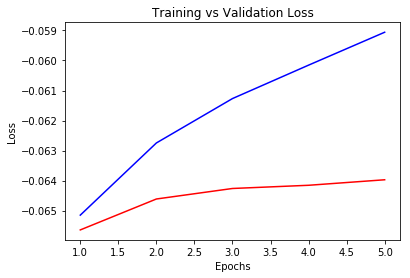

In [13]:
plt.plot(it[:5],train_loss,color='blue')
plt.plot(it[:5],dev_loss,color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [14]:
for i in range(5,10):
    f_model.fit(X_train,Y_train,epochs=1, batch_size=32)
    
    train_p = np.array(f_model.predict(X_train))
    train_los = np.mean(weights*(Y_train*np.log(train_p)+(1-Y_train)*np.log(1-train_p)))
    train_loss.append(train_los)
    print('Iteration '+str(i+1)+':')
    print('Training loss = '+str(train_los))
    
    dev_p = np.array(f_model.predict(X_dev))
    dev_los = np.mean(weights*(Y_dev*np.log(dev_p)+(1-Y_dev)*np.log(1-dev_p)))
    dev_loss.append(dev_los)
    print('Validation loss = '+str(dev_los))

Epoch 1/1
32000/32000 [==============================] - 507s 16ms/step - loss: 0.0591
Iteration 6:
Training loss = -0.058272647890781605
Validation loss = -0.06393567169090197
Epoch 1/1
32000/32000 [==============================] - 508s 16ms/step - loss: 0.0582
Iteration 7:
Training loss = -0.05743337957184418
Validation loss = -0.06435360328819822
Epoch 1/1
32000/32000 [==============================] - 508s 16ms/step - loss: 0.0574
Iteration 8:
Training loss = -0.05650396217090853
Validation loss = -0.06399173938841968
Epoch 1/1
32000/32000 [==============================] - 508s 16ms/step - loss: 0.0566
Iteration 9:
Training loss = -0.05589886055614385
Validation loss = -0.06348838659592276
Epoch 1/1
32000/32000 [==============================] - 508s 16ms/step - loss: 0.0559
Iteration 10:
Training loss = -0.05533454852843073
Validation loss = -0.06391313525813228


Text(0,0.5,'Loss')

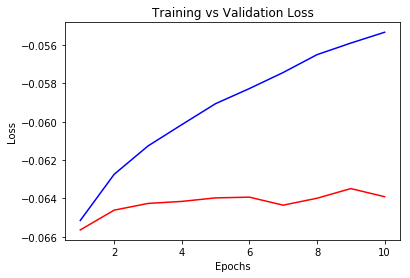

In [15]:
plt.plot(it,train_loss,color='blue')
plt.plot(it,dev_loss,color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
#PREDICT

In [32]:
train_pred = f_model.predict(X_train)

In [33]:
dev_pred = f_model.predict(X_dev)

In [16]:
test_pred = f_model.predict(X_test)

In [36]:
#CUSTOM THRESHOLD

ratios = np.average(Y_train,axis=0)
print(ratios)
print(train_pred.shape)
thresholds = []
for i in range(len(ratios)):
    thresholds.append(np.percentile(train_pred[:,i],100*(1-ratios[i])))
print(thresholds)

[0.286 0.543 0.559 0.511 0.313 0.68  0.733 0.34  0.571]
(32000, 9)
[0.4238448988199234, 0.49719242003560066, 0.47197262993454925, 0.5422455159425735, 0.3406495490670204, 0.5671055936813354, 0.5843763421773911, 0.3385184407234192, 0.5813223873972894]


In [39]:
#THRESHOLDING DEV

biz_pred_avg = np.empty((32,9))
biz_pred_max = np.empty((32,9))
for k in range(32):
    biz_pred_avg[k]=(np.sum(dev_pred[32*k:32*(k+1)],axis=0)/32)
    for l in range(9):
        biz_pred_max[k,l]=max(dev_pred[32*k:32*(k+1),l])


for i in range(9):
    #biz_pred[:,i] = biz_pred[:,i] >= thresholds[i]
    biz_pred_avg[:,i] = biz_pred_avg[:,i] >= 0.5
    biz_pred_max[:,i] = biz_pred_max[:,i] >= 0.5

# print(biz_pred)
# print(Y_dev)

In [26]:
#THRESHOLDING TEST

biz_pred_avg = np.empty((32,9))
biz_pred_max = np.empty((32,9))
for k in range(32):
    biz_pred_avg[k]=(np.sum(test_pred[32*k:32*(k+1)],axis=0)/32)
    for l in range(9):
        biz_pred_max[k,l]=max(test_pred[32*k:32*(k+1),l])


for i in range(9):
    #biz_pred[:,i] = biz_pred[:,i] >= thresholds[i]
    biz_pred_avg[:,i] = biz_pred_avg[:,i] >= thresholds[i]
    biz_pred_max[:,i] = biz_pred_max[:,i] >= thresholds[i]

# print(biz_pred)
# print(Y_dev)

In [28]:
#THRESHOLDING TRAIN

biz_pred_avg = np.empty((1000,9))
biz_pred_max = np.empty((1000,9))
for k in range(1000):
    biz_pred_avg[k]=(np.sum(train_pred[32*k:32*(k+1)],axis=0)/32)
    for l in range(9):
        biz_pred_max[k,l]=max(train_pred[32*k:32*(k+1),l])


for i in range(9):
    #biz_pred[:,i] = biz_pred[:,i] >= thresholds[i]
    biz_pred_avg[:,i] = biz_pred_avg[:,i] >= thresholds[i]
    biz_pred_max[:,i] = biz_pred_max[:,i] >= thresholds[i]

In [29]:
#F1S FOR TRAIN

f1s_avg = []
f1s_max = []
    
for i in range(9):
    f1s_avg.append(f1_score(Y_train[::32,i],biz_pred_avg[:,i]))
    f1s_max.append(f1_score(Y_train[::32,i],biz_pred_max[:,i]))
    
print('Average:')
print(f1s_avg)
meanf1_avg = mean(f1s_avg)
print(meanf1_avg)

print('Max:')
print(f1s_max)
meanf1_max = mean(f1s_max)
print(meanf1_max)

Average:
[0.7109375, 0.8771610555050044, 0.9078014184397163, 0.8290840415486308, 0.8229508196721312, 0.9196234612599566, 0.9495081967213114, 0.8088235294117648, 0.8875110717449071]
0.8570445660337136
Max:
[0.463038180341186, 0.7051948051948053, 0.7185089974293059, 0.6763732627399073, 0.49960095770151636, 0.8095238095238095, 0.845931909982689, 0.5234795996920708, 0.7273885350318472]
0.663226673070793


In [40]:
#F1S FOR DEV

f1s_avg = []
f1s_max = []
    
for i in range(9):
    f1s_avg.append(f1_score(Y_dev[::32,i],biz_pred_avg[:,i]))
    f1s_max.append(f1_score(Y_dev[::32,i],biz_pred_max[:,i]))
    
print('Average:')
print(f1s_avg)
meanf1_avg = mean(f1s_avg)
print(meanf1_avg)

print('Max:')
print(f1s_max)
meanf1_max = mean(f1s_max)
print(meanf1_max)

Average:
[0.18181818181818182, 0.8648648648648648, 0.7878787878787877, 0.6938775510204082, 0.0, 0.8333333333333333, 0.8679245283018869, 0.14285714285714288, 0.8750000000000001]
0.5830615988971785
Max:
[0.5, 0.7924528301886793, 0.72, 0.72, 0.4444444444444445, 0.8148148148148148, 0.8363636363636363, 0.6666666666666666, 0.7924528301886793]
0.6985772469629912


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
#F1S FOR TEST

f1s_avg = []
f1s_max = []
    
for i in range(9):
    f1s_avg.append(f1_score(Y_test[:,i],biz_pred_avg[:,i]))
    f1s_max.append(f1_score(Y_test[:,i],biz_pred_max[:,i]))
    
print('Average:')
print(f1s_avg)
meanf1_avg = mean(f1s_avg)
print(meanf1_avg)

print('Max:')
print(f1s_max)
meanf1_max = mean(f1s_max)
print(meanf1_max)

Average:
[0.37499999999999994, 0.7586206896551724, 0.9032258064516129, 0.7407407407407408, 0.9411764705882353, 0.9047619047619048, 0.923076923076923, 0.7777777777777778, 0.9]
0.8027089236724853
Max:
[0.5365853658536585, 0.6666666666666666, 0.6666666666666666, 0.5777777777777777, 0.4324324324324324, 0.7692307692307693, 0.8571428571428571, 0.43902439024390244, 0.7450980392156863]
0.6322916628033797


In [26]:
f_model.save_weights('finetuned_vgg19_weights-10ep.h5')